In [ ]:
import warnings
warnings.filterwarnings("ignore")

Decision-Tree for Classification

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
dt = DecisionTreeClassifier(criterion='gini', random_state=1, max_depth=2)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_test, y_pred)

0.9333333333333333

Decision-Tree for Regression

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=3)
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1, random_state=3)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
mse_dt = MSE(y_test, y_pred)
rmse_dt = mse_dt**(1/2)
print(rmse_dt)

55.512621799818966


Учитывая, что ошибка train меньше, чем CV-ошибка, можем сделать вывод, что dt переобучается на тренировочном наборе и что он страдает от высокой дисперсии.

Обратите внимание, что ошибки CV и тестового набора примерно равны:
*   если CV-ошибка > train-ошибка то высокая дисперсия
*   если СV-ошибка = train-ошибки но выше чем желаемая - высокое смещение




In [ ]:
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.14, random_state=123)

MSE_CV = - cross_val_score(dt, X_train, y_train, cv= 10, scoring='neg_mean_squared_error', n_jobs = -1)
dt.fit(X_train, y_train)
y_predict_train = dt.predict(X_train)
y_predict_test = dt.predict(X_test)

print('CV MSE: {:.2f}'.format(MSE_CV.mean())) #20.51 CV MSE
print('Train MSE: {:.2f}'.format(MSE(y_train, y_predict_train))) #15.30  Training set MSE
print('Test MSE: {:.2f}'.format(MSE(y_test, y_predict_test))) #20.92 Test set MSE

CV MSE: 4205.85
Train MSE: 3253.94
Test MSE: 4193.61


Простое голосование в ансамбле

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 1, shuffle = True)
lr = LogisticRegression(random_state=123)
knn = KNN()
dt = DecisionTreeClassifier(random_state=123)
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

for clf_name, clf in classifiers:
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred))) #Logistic Regression: 0.947

vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
print('Voting Classifier: {}'.format(accuracy_score(y_test, y_pred)))

Logistic Regression : 0.978
K Nearest Neighbours : 0.978
Classification Tree : 0.956
Voting Classifier: 0.9555555555555556


* Усреднение (мягкое голосование) - для регрессии и классификации (вероятности)
* Голосование (мажоритарное голосование) - для классификации

In [ ]:
from sklearn.ensemble import VotingClassifier # класс
clf_knn = KNeighborsClassifier(5)
clf_dt = DecisionTreeClassifier()
clf_lr = LogisticRegression()

clf_voting = VotingClassifier(estimators=[('knn', clf_knn), ('dt', clf_dt), ('lr', clf_lr)])
clf_voting.fit(X_train, y_train)
y_pred = clf_voting.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:0.3f}".format(acc))

In [ ]:
from sklearn.ensemble import VotingClassifier # Averaging Classifier
clf_voting = VotingClassifier(estimators=[('label1', clf_1), ('label2', clf_2), ... ('labelN', clf_N)],
                              voting='soft', #Значение по умолчанию — «hard»
                              weights=[w_1, w_2, ..., w_N])

from sklearn.ensemble import VotingRegressor # Averaging Regressor
reg_voting = VotingRegressor(estimators=[('label1', reg_1), ('label2', reg_2), ... ('labelN', reg_N)],
                             weights=[w_1, w_2, ..., w_N])
#можем передать необязательные веса параметров, которые определяют вес для каждого из оценщиков

In [ ]:
# пример
clf_knn = KNeighborsClassifier(5)
clf_dt = DecisionTreeClassifier()
clf_lr = LogisticRegression() # LogisticRegression(class_weight = 'balanced')
clf_voting = VotingClassifier(estimators=[
                               ('knn', clf_knn),
                               ('dt', clf_dt),
                               ('lr', clf_lr)], voting='soft', weights=[1, 2, 1])
#clf_lr = LogisticRegression(class_weight='balanced')
#clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)
#clf_svm = SVC(probability=True, class_weight='balanced', random_state=500) - вероятности

Bagging

In [ ]:
# хотят слабых моделей
model = DecisionTreeClassifier(max_depth=3) # огр-ие глубины
model = LogisticRegression(max_iter=50, C=100.0) # кол-во итерация и регуляризация
model = LinearRegression()
#Линейная регрессия, как и логистическая регрессия, предполагает, что выходные данные
#являются линейной функцией входных признаков. Кроме того, он опирается на независимость этих функций

Почему bagging является полезной техникой? Во-первых, это помогает уменьшить дисперсию, так как выборка действительно случайна. Bias также может быть уменьшена, поскольку мы используем голосование или усреднение для объединения моделей. Из-за большого количества используемых оценщиков bagging обеспечивает стабильность и надежность. Однако bagging требует больших вычислительных ресурсов с точки зрения пространства и времени.

Параметры по улучшению bagging

* base_estimator
* n_estimators - чем больше тем лучше
* oob_score (вызов est_bag.oob_score_)

* max_samples (подвыборка)
* max_features (class sqrt(признаки), рег признаки/3)
* bootstrap (по дефолту True, тогда max_sample = 1; False max_sample < 1)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16, random_state=123)

bc = BaggingClassifier(base_estimator=dt, n_estimators=300, n_jobs=-1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))

Accuracy of Bagging Classifier: 0.956


In [ ]:
# out-of-bag
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16, random_state=123)
bc = BaggingClassifier(base_estimator=dt, n_estimators=300, oob_score=True, n_jobs=-1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
oob_accuracy = bc.oob_score_
print('Test set accuracy: {:.3f}'.format(test_accuracy)) # 0.936
print('OOB accuracy: {:.3f}'.format(oob_accuracy)) # 0.925
# Однако это часто ниже, чем фактическая производительность

Test set accuracy: 0.956
OOB accuracy: 0.933


Random Forest

In [ ]:
import pandas as pd
data_auto = pd.read_csv('/content/auto.csv')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
X_auto, y_auto = data_auto.drop(columns = ['mpg', 'origin']), data_auto['mpg']
X_train, X_test, y_train, y_test = train_test_split(X_auto, y_auto, test_size=0.3, random_state=1)
rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=0.12, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 3.98


Tree-specific parameters:
* n_estimators
* max_features
* oob_score
* max_depth - глубина
* min_samples_split - , минимальное количество образцов, необходимых для разделения узла
* min_samples_leaf - минимальное количество образцов, необходимых для листового узла
* class_weight ( “balanced” ) - вес класса (справляется с несбалансированными классами)

Если обучается метод основанный на дереве то можно получить оуенку значимости признака (как узлы дерева используют его)

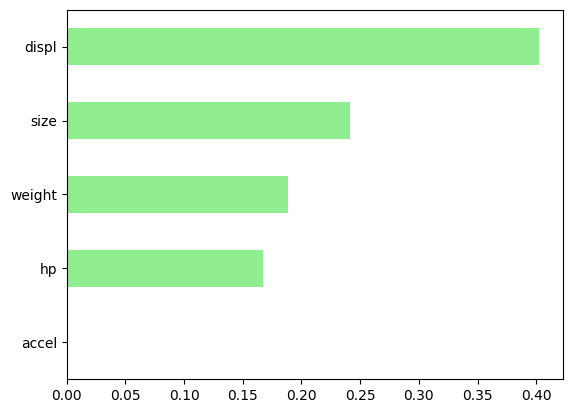

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
importances_rf = pd.Series(rf.feature_importances_, index = X_auto.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='lightgreen'); plt.show() #% вес признака в обучении и прогнозировании
# удаленный категориальный признак не влияет

AdaBoost

AdaBoostClassifier:

* base_estimator - по дефолту дерево с глубиной 1

* n_estimators - по дефолту 50 (Если есть идеальное соответствие или оценщик с погрешностью более 50%, оценщики больше не строятся)

* learning_rate - показывает, какой вклад вносит каждый оценщик в ансамбль. По умолчанию это 1.0. Существует компромисс между количеством оценщиков и скоростью обучения.

AdaBoostRegressor
* base_estimator - по дефолту Decision Tree (max_depth=3)

* loss: linear (default), square, exponentia

Есть параметр потерь, который является функцией, используемой для обновления весов (умолчанию он линейный)

In [ ]:
#у каждого предиктора появляется вес альфа
iris = load_iris()
X, y = iris.data, iris.target
X, y = X[:100], y[:100]

from sklearn.ensemble import AdaBoostClassifier #AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
dt = DecisionTreeClassifier(max_depth=1, random_state=1)
adb_clf = AdaBoostClassifier(base_estimator=dt, n_estimators=100)

dt = DecisionTreeClassifier(max_depth=1, random_state=1)
adb_clf = AdaBoostClassifier(base_estimator=dt, n_estimators=100)
adb_clf.fit(X_train, y_train)

y_pred_proba = adb_clf.predict_proba(X_test)[:,1]

adb_clf_roc_auc_score = roc_auc_score(y_test, y_pred_proba) #вероятность
print('ROC AUC score: {:.2f}'.format(adb_clf_roc_auc_score))

ROC AUC score: 1.00


In [ ]:
reg_ada = AdaBoostRegressor(base_estimator, n_estimators, learning_ rate, loss)

reg_lm = LinearRegression()
reg_ada = AdaBoostRegressor(n_estimators = 12, loss = 'linear', random_state=500, base_estimator = reg_lm)
reg_ada.fit(X_train, y_train)

pred = reg_ada.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE: {:.3f}'.format(rmse))

Gradient Boosting

Здесь не указываем base_estimator, так как Gradient Boosting реализован и оптимизирован с помощью деревьев регрессии

n_estimators (Default: 100)

learning_rate (Default: 0.1)

max_depth (Default: 3)

min_samples_split (для разделения)

min_samples_leaf (для листа)

max_features (рекомендуют все)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
X_train, X_test, y_train, y_test = train_test_split(X_auto,y_auto, test_size=0.3, random_state=1)

gbt = GradientBoostingRegressor(n_estimators=300, max_depth=1, random_state=1)
gbt.fit(X_train, y_train)
y_pred = gbt.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE: {:.2f}'.format(rmse_test))

Test set RMSE: 4.08


Stochastic Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X_auto,y_auto, test_size=0.3, random_state=SEED)
# Instantiate a stochastic GradientBoostingRegressor 'sgbt'
sgbt = GradientBoostingRegressor(max_depth=1, subsample=0.8, max_features=0.2, n_estimators=300, random_state=SEED) #параметр subsample = 0.8
sgbt.fit(X_train, y_train)
y_pred = sgbt.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE: {:.2f}'.format(rmse_test))

Test set RMSE: 4.28


Hyperparameters of a CART

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=SEED) #print(dt.get_params())
from sklearn.model_selection import GridSearchCV
params_dt = {'max_depth': [3, 4, 5, 6], 'min_samples_leaf': [0.04, 0.06, 0.08], 'max_features': [0.2, 0.4,0.6, 0.8]}
grid_dt = GridSearchCV(estimator=dt, param_grid=params_dt, scoring='accuracy', cv=10, n_jobs=-1)
grid_dt.fit(X_train, y_train)

best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams) #Best hyerparameters: {'max_depth': 3,'max_features': 0.4, 'min_samples_leaf': 0.06}
best_CV_score = grid_dt.best_score_
print('Best CV accuracy'.format(best_CV_score)) #Best CV accuracy: 0.938

best_model = grid_dt.best_estimator_
test_acc = best_model.score(X_test,y_test)
print("Test set accuracy of best model: {:.3f}".format(test_acc))

Tuning an RF's Hyperparameters

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state= SEED)
rf.get_params()
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
params_rf = {'n_estimators': [300, 400, 500],'max_depth': [4, 6, 8],'min_samples_leaf': [0.1, 0.2], 'max_features': ['log2', 'sqrt']}
grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams) #Best hyperparameters: {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'n_estimators': 400}
best_model = grid_rf.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

XGBoost

XGBoost использует **параллельную обработку** для обучения каждого оценщика, тем самым ускоряя обработку

In [ ]:
import xgboost as xgb # (можно XGBRegressor)
clf_xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=None, max_depth=None, random_state)
clg_xgb.fit(X_train, y_train) # learning_rate и max_depth не имеют значения по умолчанию (надо указывать)
pred = clf_xgb.predict(X_test)

LightGBM

In [ ]:
import lightgbm as lgb # можно LGBMRegressor
clf_lgb = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state)
clf_lgb.fit(X_train, y_train) # максимальная глубина, которая по умолчанию отрицательна
# что означает отсутствие ограничений. Следовательно, мы должны указать его значение, если требуется предел.
pred = clf_lgb.predict(X_test) # лепи дальше sklearn

CatBoost

In [ ]:
import catboost as cb #(CatBoostClassifier и CatBoostRegressor)
clf_cat = cb.CatBoostClassifier(n_estimators=None, learning_rate=None, max_depth=None, random_state)
clf_cat.fit(X_train, y_train)
pred = clf_cat.predict(X_test)
#CatBoost имеет встроенную возможность обработки категориальных функций, поэтому вам не нужно
#выполнять предварительную обработку самостоятельно

In [ ]:
# примеры
reg_xgb = xgb.XGBRegressor(max_depth = 3, learning_rate = 0.1, n_estimators = 100, n_jobs=2, objective='reg:squarederror', random_state=500)
reg_xgb.fit(X_train, y_train)

reg_lgb = lgb.LGBMRegressor(max_depth = 3, learning_rate = 0.1, n_estimators = 100, objective='mean_squared_error', seed=500)
reg_lgb.fit(X_train, y_train)

pred_xgb = reg_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
pred_lgb = reg_lgb.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, pred_lgb))
print('Extreme: {:.3f}, Light: {:.3f}'.format(rmse_xgb, rmse_lgb))

import catboost as cb
reg_cat = cb.CatBoostRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state=500)
reg_cat.fit(X_train, y_train)
pred = reg_cat.predict(X_test)

rmse_cat = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE (CatBoost): {:.3f}'.format(rmse_cat))

Stacking

Шаг первый, подготовьте набор данных.

Шаг второй: постройте оценки первого уровня.

Шаг третий: добавьте прогнозы отдельных оценщиков к исходному набору данных.

Шаг четвертый: создайте мета-оценщик второго уровня.

И пятый шаг: используйте модель сложенного ансамбля для окончательных прогнозов.

In [ ]:
# Stacking classifier
from sklearn.ensemble import StackingClassifier
classifiers = [('clf1', Classifier1(params1)),
               ('clf2', Classifier2(params2)),
                            ...
               ('clfN', ClassifierN(paramsN))]
# Instantiate the 2nd-layer classifier
clf_meta = ClassifierMeta(paramsMeta)

clf_stack = StackingClassifier(estimators=classifiers, final_estimator=clf_meta,
                               cv=5, stack_method='predict_proba', passthrough=False)
clf_stack.fit(X_train, y_train)
pred = clf_stack.predict(X_test)

In [ ]:
# Стекинг регрессора
from sklearn.ensemble import StackingRegressor
# Instantiate the 1st-layer regressors
regressors = [('reg1', Regressor1(params1)),
              ('reg2', Regressor2(params2)),
                       ...
              ('regN', RegressorN(paramsN))]
reg_meta = RegressorMeta(paramsMeta)
reg_stack = StackingRegressor( estimators=regressors, final_estimator=reg_meta,
                              cv=5, passthrough=False)
reg_stack.fit(X_train, y_train) # Параметр stack_method отсутствует, так как это регрессор
pred = reg_stack.predict(X_test)

In [ ]:
#пример
clf_dt = DecisionTreeClassifier(min_samples_leaf = 3, min_samples_split = 9, random_state=500)
clf_dt.fit(X_train, y_train)

clf_knn = KNeighborsClassifier(algorithm = 'ball_tree', n_neighbors = 5)
clf_knn.fit(X_train, y_train)

print('Decision Tree: {:0.4f}'.format(accuracy_score(clf_dt.predict(X_test), y_test)))
print('5-Nearest Neighbors: {:0.4f}'.format(accuracy_score(clf_knn.predict(X_test), y_test)))

classifiers = [('clf_dt', clf_dt), ('clf_knn', clf_knn)]

clf_meta = LogisticRegression()

clf_stack = StackingClassifier(estimators=classifiers, final_estimator=clf_meta,
                               passthrough=False, stack_method='predict_proba')
clf_stack.fit(X_train, y_train)
pred_stack = clf_stack.predict(X_test)
print('Accuracy: {:0.4f}'.format(accuracy_score(pred_stack, y_test)))

MLxtend

Библиотекой Mlxtend позволяет легко создавать ансамбли стекирования

In [ ]:
from mlxtend.classifier import StackingClassifier
clf1 = Classifier1(params1)
clf2 = Classifier2(params2)
...
clfN = ClassifierN(paramsN)

clf_meta = ClassifierMeta(paramsMeta)

clf_stack = StackingClassifier(classifiers=[clf1, clf2, ... clfN], meta_classifier=clf_meta,
                               use_probas=False, use_features_in_secondary=False)
clf_stack.fit(X_train, y_train)
pred = clf_stack.predict(X_test)

In [ ]:
from mlxtend.regressor import StackingRegressor
reg1 = Regressor1(params1)
reg2 = Regressor2(params2)
...
regN = RegressorN(paramsN)

reg_meta = RegressorMeta(paramsMeta)

reg_stack = StackingRegressor(regressors=[reg1, reg2, ... regN], meta_regressor=reg_meta,
                              use_features_in_secondary=False)
reg_stack.fit(X_train, y_train)
pred = reg_stack.predict(X_test)

In [ ]:
# пример
clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
clf_meta = LogisticRegression()
clf_stack = StackingClassifier(classifiers=[clf_dt, clf_knn], meta_classifier=clf_meta,
                               use_probas=True, use_features_in_secondary=False)
clf_stack.fit(X_train, y_train)

pred_stack = clf_stack.predict(X_test)
print("Accuracy: {:0.4f}".format(accuracy_score(y_test, pred_stack)))

# пример
reg_dt = DecisionTreeRegressor(min_samples_leaf=11, min_samples_split=33, random_state=500)
reg_lr = LinearRegression()
reg_ridge = Ridge(random_state=500)

reg_meta = LinearRegression()

reg_stack = StackingRegressor(regressors=[reg_dt, reg_lr, reg_ridge], meta_regressor=reg_meta)
reg_stack.fit(X_train, y_train)

pred = reg_stack.predict(X_test)
print('MAE: {:.3f}'.format(mean_absolute_error(y_test, pred)))